In [2]:
import tensorflow as tf

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

In [4]:
df = pd.read_csv('./spam.csv', encoding='ISO-8859-1')

In [5]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [7]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
# rename columns to something better
df.columns = ['labels', 'data']

In [9]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values

In [10]:
# split up the data
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

In [11]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [12]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 7118 unique tokens.


In [13]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (3733, 162)


In [14]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (1839, 162)


In [15]:
# Create the model

# We get to choose embedding dimensionality
D = 20

# Hidden state dimensionality
M = 20

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

In [16]:
df[df['labels'] == 'spam'].size / df.size

0.13406317300789664

In [17]:
df[df['labels'] == 'ham'].size / df.size

0.8659368269921034

In [18]:
spam_freq = df[df['labels'] == 'spam'].size / df.size

In [19]:
# Compile and fit
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  data_train,
  Ytrain,
  epochs=5,
  validation_data=(data_test, Ytest),
  class_weight={0: 1, 1: 1 / spam_freq}
)

Training model...
Epoch 1/5
117/117 [==============================] - 4s 16ms/step - loss: 1.0331 - accuracy: 0.4144 - val_loss: 0.5391 - val_accuracy: 0.9810
Epoch 2/5
117/117 [==============================] - 2s 13ms/step - loss: 0.4951 - accuracy: 0.9858 - val_loss: 0.3214 - val_accuracy: 0.9685
Epoch 3/5
117/117 [==============================] - 2s 13ms/step - loss: 0.2390 - accuracy: 0.9885 - val_loss: 0.1209 - val_accuracy: 0.9869
Epoch 4/5
117/117 [==============================] - 2s 13ms/step - loss: 0.1280 - accuracy: 0.9957 - val_loss: 0.0833 - val_accuracy: 0.9869
Epoch 5/5
117/117 [==============================] - 1s 12ms/step - loss: 0.0817 - accuracy: 0.9971 - val_loss: 0.0930 - val_accuracy: 0.9793


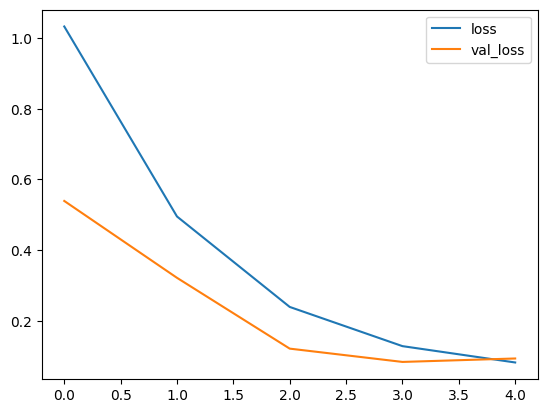

In [20]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

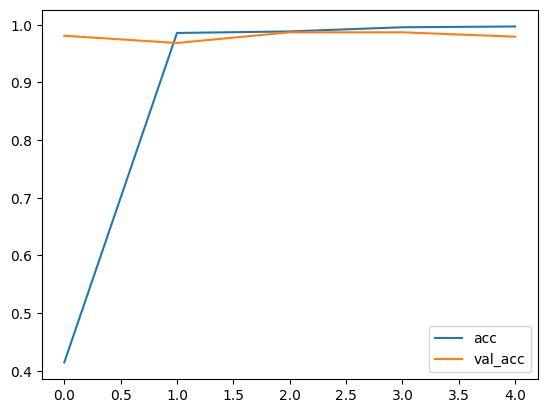

In [21]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

58/58 [==============================] - 0s 3ms/step
Confusion matrix, without normalization
[[1551   21]
 [  17  250]]


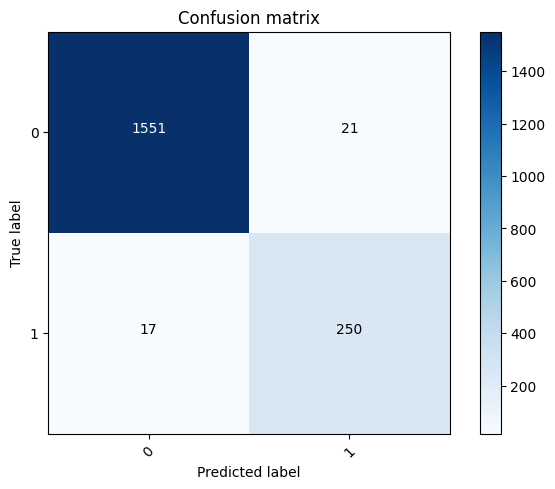

In [22]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


p_test = np.round(model.predict(data_test))
cm = confusion_matrix(Ytest, p_test)
plot_confusion_matrix(cm, [0, 1])

117/117 [==============================] - 0s 3ms/step
Confusion matrix, without normalization
[[3229   24]
 [   2  478]]


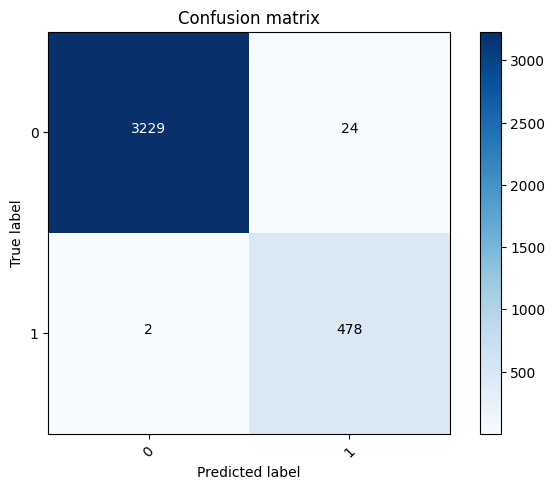

In [23]:
p_train = np.round(model.predict(data_train))
cm = confusion_matrix(Ytrain, p_train)
plot_confusion_matrix(cm, [0, 1])

In [24]:
### Make predictions on a new test sentence ###
test_sent = df[df.labels == 'ham'].sample()['data'].values
# test_sent = ['Not heard from U4 a while. Call 4 rude chat private line']
print("Sentence:", test_sent)
test_seq = tokenizer.texts_to_sequences(test_sent)
test_seq

Sentence: ['Pls send me your address sir.']


[[111, 67, 10, 13, 625, 304]]

In [25]:
test_padded = pad_sequences(test_seq, maxlen=T)
test_padded

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        111,  67,  10,  13, 625, 304]])

In [26]:
# correctly identified as spam
model.predict(test_padded)

1/1 [==============================] - 0s 19ms/step


array([[0.0393011]], dtype=float32)